<a href="https://colab.research.google.com/github/SunGod1998/Summer_Internship_2020/blob/master/DeepTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))   

Saving Price_All.csv to Price_All.csv
User uploaded file "Price_All.csv" with length 1527571 bytes


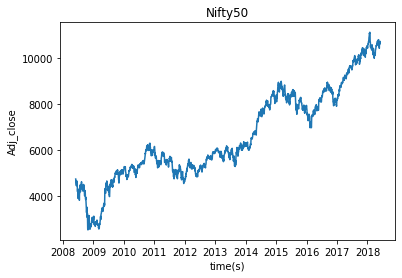

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf

df=pd.read_csv("Price_All.csv")
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
scaler=MinMaxScaler()

fig, ax = plt.subplots()
ax.plot(df["Date"], df["Price_51"])

ax.set(xlabel='time(s)', ylabel='Adj_close',
       title='Nifty50')
fig.savefig("benchmark.png")
plt.show()

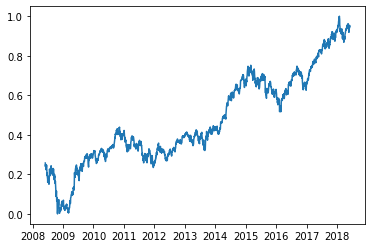

In [7]:
D=np.asarray(df)
D=D[:,1:]
#D=(D-np.mean(D,axis=0))/np.std(D)
#plt.plot(D)
D=scaler.fit_transform(D)
plt.plot(df.index,D[:,-1])

In [9]:
#Implementing the seq2seq LSTM autoencoder and extract the top K stocks 
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model

df.head(3)
X_AE=df.drop("Date",axis=1)
scaled_X_AE=scaler.fit_transform(X_AE)
Data=scaled_X_AE
#Data=scaled_X_AE.T
Data=np.reshape(Data,(1,Data.shape[0],Data.shape[1]))
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(Data.shape[1],Data.shape[2]),return_sequences=True,name='Enc_1'))
model.add(TimeDistributed(Dropout(0.3)))
model.add(LSTM(40, activation='relu', return_sequences=True,name='Enc_1_1'))
model.add(TimeDistributed(Dense(Data.shape[2]),name='dec_1'))
model.compile(optimizer='adam', loss='mse')

hist=model.fit(Data,Data,epochs=85,batch_size=1)

model=Model(inputs=model.inputs, outputs=model.layers[3].output)
decoded_data=model.predict(Data)
decoded_data.shape


Epoch 1/85
1/1 [==============================] - 3s 3s/step - loss: 0.2341
Epoch 2/85
1/1 [==============================] - 2s 2s/step - loss: 0.2200
Epoch 3/85
1/1 [==============================] - 2s 2s/step - loss: 0.2054
Epoch 4/85
1/1 [==============================] - 2s 2s/step - loss: 0.1916
Epoch 5/85
1/1 [==============================] - 2s 2s/step - loss: 0.1780
Epoch 6/85
1/1 [==============================] - 2s 2s/step - loss: 0.1648
Epoch 7/85
1/1 [==============================] - 2s 2s/step - loss: 0.1501
Epoch 8/85
1/1 [==============================] - 2s 2s/step - loss: 0.1406
Epoch 9/85
1/1 [==============================] - 2s 2s/step - loss: 0.1304
Epoch 10/85
1/1 [==============================] - 2s 2s/step - loss: 0.1244
Epoch 11/85
1/1 [==============================] - 2s 2s/step - loss: 0.1184
Epoch 12/85
1/1 [==============================] - 2s 2s/step - loss: 0.1130
Epoch 13/85
1/1 [==============================] - 2s 2s/step - loss: 0.1076
Epoch 14

(1, 2441, 47)

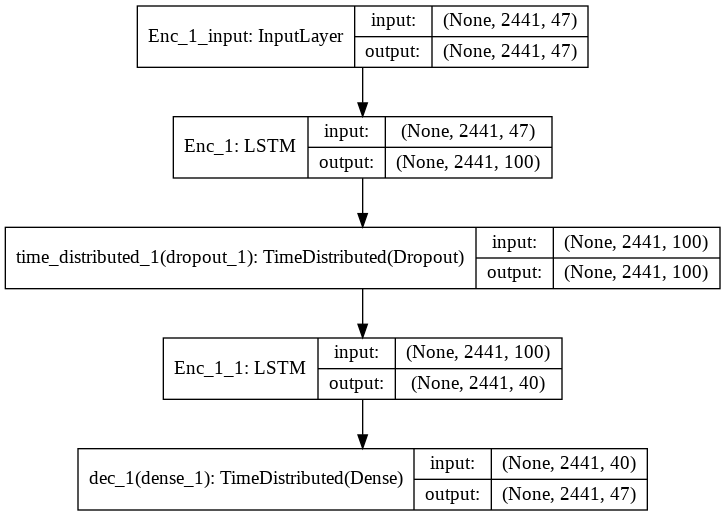

In [10]:
plot_model(model,show_shapes=True,show_layer_names=True)

[44 25 46 14 19  2 29 45 36  6 28 21  4 40  0 11 27 43  8  9 24  5  1 17
 35 18 33 41 37 26 22 16 39 12  3 15 32 42 23 10 30 34 13 38 20  7 31]


'\ns=np.max(s,axis=0)\ncolumns=np.asarray(df.columns[1:-1])\n\ncol_05=ma.masked_array(columns,mask=mask_05)\ncolumns_used=list(col_05.compressed())\ncolumns_used\n'

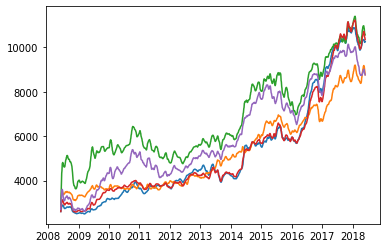

In [113]:
import numpy as np

d_1=np.reshape(Data,(Data.shape[1],Data.shape[2]))
d_2=np.reshape(decoded_data,(Data.shape[1],Data.shape[2]))
d_1=scaler.inverse_transform(d_1)
d_2=scaler.inverse_transform(d_2)
rep_data=d_1-d_2

sim=np.linalg.norm(rep_data,axis=0)
ind=np.argsort(sim)
print(str(ind))
plt.plot(df.index,d_2[:,[44,25,46,14,19]])

'''
s=np.max(s,axis=0)
columns=np.asarray(df.columns[1:-1])

col_05=ma.masked_array(columns,mask=mask_05)
columns_used=list(col_05.compressed())
columns_used
'''

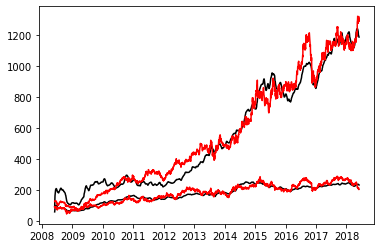

In [53]:
#CHECKPOINT: De-noised(Black) vs Original(Red)
plt.plot(df.index,d_2[:,1:3],'black',df.index,d_1[:,1:3],'r-')

In [0]:
Y=df["Price_51"]
Y=np.asarray(Y)

X=df[df.columns[ind[1:10]]]
X=scaler.fit_transform(X)

Y=Y.reshape((Y.shape[0],1))
Y=scaler.fit_transform(Y)


In [124]:
from sklearn.model_selection import train_test_split

import numpy as np

X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.30,shuffle=False)
[X_train.shape,X_test.shape,y_train.shape,y_test.shape]

[(1708, 9), (733, 9), (1708, 1), (733, 1)]

https://roamanalytics.com/2016/11/28/shape-matching-with-time-series-data/


The following portion uses the LSTM based architecture to predict the performance of the tracker

In [125]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, RepeatVector
from keras.utils import plot_model
from keras.losses import KLDivergence

X_train = np.reshape(X_train, (1708, 9,1))
X_test = np.reshape(X_test, (733, 9, 1))

model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(TimeDistributed(Dropout(0.3)))
model.add(LSTM(100,activation='relu',input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))
#model.add(Dense(20))
model.add(Dropout(0.3))
model.add(Dense(1))

#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=100000, decay_rate=0.96,staircase=True)
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="mse",optimizer=opt,metrics=['cosine'])

history=model.fit(X_train, y_train, epochs=5
                  , batch_size=10, validation_data=(X_test,y_test))
#model.summary()

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(y_test)

Train on 1708 samples, validate on 733 samples
Epoch 1/5
1708/1708 [==============================] - 3s 2ms/step - loss: 0.0120 - cosine: 0.9959 - val_loss: 0.0020 - val_cosine: 1.0000
Epoch 2/5
1708/1708 [==============================] - 3s 2ms/step - loss: 0.0046 - cosine: 0.9994 - val_loss: 0.0029 - val_cosine: 1.0000
Epoch 3/5
1708/1708 [==============================] - 3s 1ms/step - loss: 0.0034 - cosine: 0.9982 - val_loss: 0.0132 - val_cosine: 1.0000
Epoch 4/5
1708/1708 [==============================] - 3s 2ms/step - loss: 0.0032 - cosine: 0.9994 - val_loss: 0.0056 - val_cosine: 1.0000
Epoch 5/5
1708/1708 [==============================] - 3s 1ms/step - loss: 0.0027 - cosine: 0.9994 - val_loss: 0.0144 - val_cosine: 1.0000


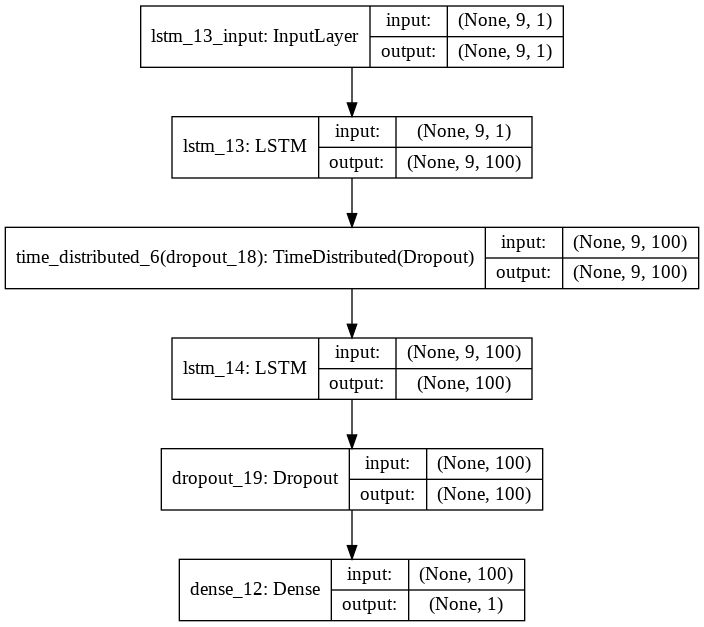

In [126]:
plot_model(model,show_shapes=True)


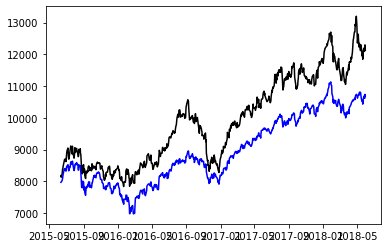

In [127]:
##prediction(black) vs truth(blue) in the testing phase
plt.plot(df.index[-733:],test_predict,'black',df.index[-733:],Y_test,'b-')#,title='Actual(blue) vs prediction(black) on test data')

Testing starts on :2015-06-11 00:00:00


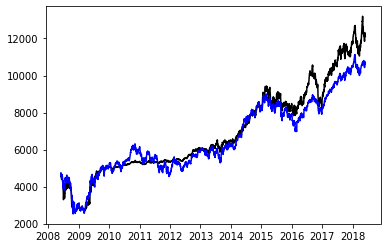

In [128]:
#prediction(black) vs truth(blue) over the entire timeline
predicted=np.concatenate((train_predict,test_predict))
plt.plot(df.index, predicted, 'black', df.index, df["Price_51"], 'blue')
test_start_date=df.index[-733]
print("Testing starts on :"+str(test_start_date))

In [73]:
import numpy as np
A=np.asarray([[1,5],[3,2]])
B=A*2
print(str(B-A)+"sqrt(10):"+str(np.sqrt(10)))
np.linalg.norm(B-A,ord=2,axis=0)

[[1 5]
 [3 2]]sqrt(10):3.1622776601683795


array([3.16227766, 5.38516481])